In [3]:
# ===============================
# IMPORTS
# ===============================
import pandas as pd
import matplotlib.pyplot as plt
import timeit
from collections import Counter
import csv
import string

import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize

import cv2
import numpy as np
import os
import imutils
from imutils.contours import sort_contours

In [4]:

# ===============================
# SETTINGS
# ===============================
from pandas import DataFrame


img_size = 32
max_train = 50000
max_val = 10000

max_images = (max_train + max_val)

train_dir = "dataset/train_v2/train"
test_dir = "dataset/test_v2/test"
val_dir   = "dataset/validation_v2/validation"

train_csv_path = "dataset/written_name_train_v2.csv"
test_csv_path = "dataset/written_name_test_v2.csv"
val_csv_path   = "dataset/written_name_validation_v2.csv"

# ===============================
# LOAD CSV LABELS
# ===============================
train_csv: DataFrame = pd.read_csv(train_csv_path)
test_csv: DataFrame = pd.read_csv(test_csv_path)
val_csv: DataFrame   = pd.read_csv(val_csv_path)

# Ensure labels are strings
train_csv["IDENTITY"] = train_csv["IDENTITY"].astype(str)
test_csv["IDENTITY"] = test_csv["IDENTITY"].astype(str)
val_csv["IDENTITY"]   = val_csv["IDENTITY"].astype(str)

train_file_to_label = dict(zip(train_csv['FILENAME'], train_csv['IDENTITY']))
test_file_to_label = dict(zip(test_csv['FILENAME'], test_csv['IDENTITY']))
val_file_to_label   = dict(zip(val_csv['FILENAME'], val_csv['IDENTITY']))

In [5]:
# ===============================
# DATASET EXPLORATION
# ===============================
print("\nTrain CSV\n",train_csv.head())
print("\nTest CSV\n",test_csv.head())
print("\nValidation CSV\n",val_csv.head())

# Counter for letters
letter_counts = Counter()

with open(train_csv_path, newline="", encoding="utf-8") as f:
    reader = csv.reader(f)
    for row in reader:
        # Join all columns into one string
        text = " ".join(row).lower()

        # Keep only alphabet letters
        for ch in text:
            if ch in string.ascii_lowercase:
                letter_counts[ch] += 1

# Print results sorted alphabetically
for letter in string.ascii_lowercase:
    print(f"{letter}: {letter_counts[letter]}")



Train CSV
           FILENAME   IDENTITY
0  TRAIN_00001.jpg  BALTHAZAR
1  TRAIN_00002.jpg      SIMON
2  TRAIN_00003.jpg      BENES
3  TRAIN_00004.jpg    LA LOVE
4  TRAIN_00005.jpg     DAPHNE

Test CSV
         FILENAME  IDENTITY
0  TEST_0001.jpg     KEVIN
1  TEST_0002.jpg  CLOTAIRE
2  TEST_0003.jpg      LENA
3  TEST_0004.jpg     JULES
4  TEST_0005.jpg   CHERPIN

Validation CSV
               FILENAME    IDENTITY
0  VALIDATION_0001.jpg       BILEL
1  VALIDATION_0002.jpg  LAUMIONIER
2  VALIDATION_0003.jpg         LEA
3  VALIDATION_0004.jpg   JEAN-ROCH
4  VALIDATION_0005.jpg        RUPP
a: 600618
b: 45966
c: 68144
d: 60504
e: 270852
f: 18288
g: 370096
h: 61724
i: 504863
j: 346765
k: 14082
l: 161202
m: 83719
n: 498167
o: 136385
p: 360564
q: 5166
r: 479325
s: 91419
t: 432511
u: 96417
v: 25094
w: 5505
x: 11342
y: 30831
z: 14177


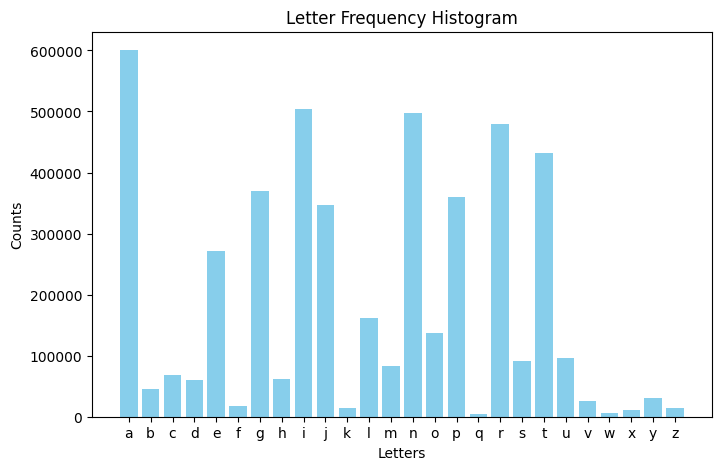

In [9]:
letters = sorted(letter_counts.keys())
counts = [letter_counts[letter] for letter in letters]

# Plot histogram
plt.figure(figsize=(8,5))
plt.bar(letters, counts, color='skyblue')
plt.xlabel('Letters')
plt.ylabel('Counts')
plt.title('Letter Frequency Histogram')
plt.show()

✅ Loaded image shape: (31, 284, 3)


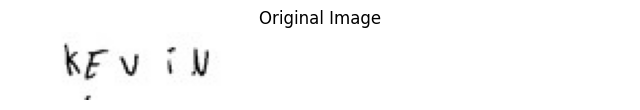

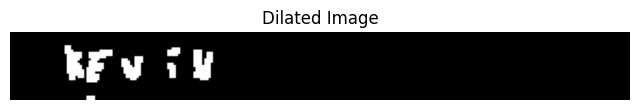

➡️ Contour 0: ROI shape = (18, 11)
➡️ Contour 2: ROI shape = (17, 14)
➡️ Contour 3: ROI shape = (13, 12)
➡️ Contour 4: ROI shape = (9, 6)
➡️ Contour 5: ROI shape = (6, 8)
➡️ Contour 6: ROI shape = (16, 11)


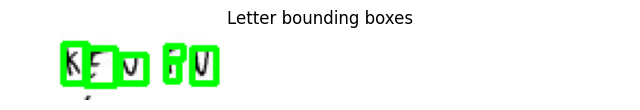

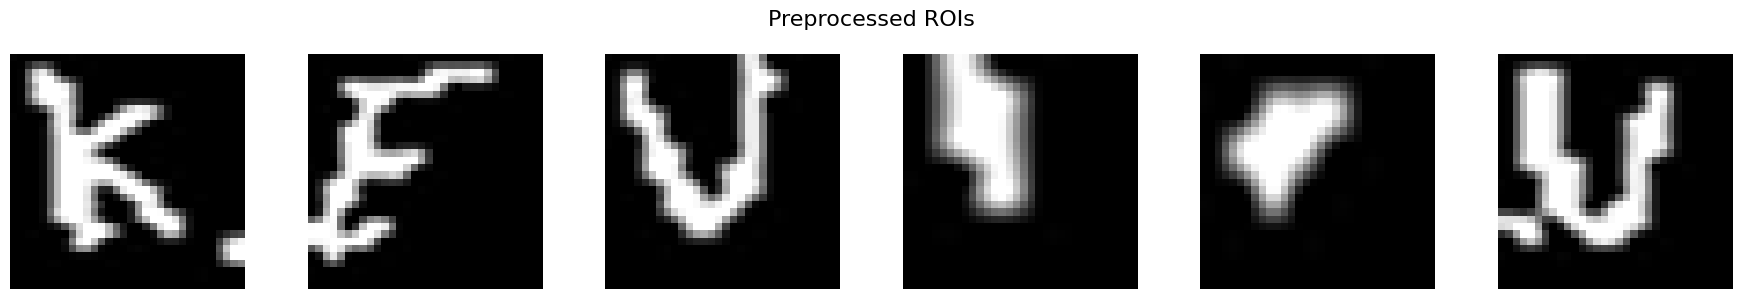

In [ ]:
# ===============================
# MANUAL LETTER SPLITTER
# ===============================

def get_bounding_boxes(img_path: str, show_plts = False):
    if not os.path.exists(img_path):
        print("❌ Error: File not found at", img_path)
        return [], None

    image = cv2.imread(img_path)
    if image is None:
        print("❌ Error: Could not read the image. Check file format or path.")
        return [], None
    
    if show_plts:
        print("✅ Loaded image shape:", image.shape)


        plt.figure(figsize=(8,6))
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.title("Original Image")
        plt.show()

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Threshold + dilation
    # Flip image to be black on white instead of white on black 
    # Fill holes in contours
    _, thresh1 = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY_INV)
    dilated = cv2.dilate(thresh1, kernel=filter_kernel, iterations=2)

    if show_plts:
        plt.figure(figsize=(8,6))
        plt.imshow(cv2.cvtColor(dilated, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.title("Dilated Image")
        plt.show()

    # Find contours
    cnts = cv2.findContours(dilated.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)

    if len(cnts) == 0:
        if show_plts:
            print("Detected 0 letters: ", img_path)
        return image, []

    cnts = sort_contours(cnts, method="left-to-right")[0]

    letters = []

    for i, c in enumerate(cnts):
        if cv2.contourArea(c) < 10:
            continue
        x, y, w, h = cv2.boundingRect(c)

        # add buffer area
        w += 2
        h += 2

        x -= 1
        y -= 1

        # Extract ROI
        roi = gray[y:y+h, x:x+w]

        # Safety check
        if roi.size == 0 or roi.shape[0] == 0 or roi.shape[1] == 0:
            if show_plts:
                print(f"⚠️ Skipping empty ROI at contour {i} -> x={x}, y={y}, w={w}, h={h}")
            continue
        if show_plts:
            print(f"➡️ Contour {i}: ROI shape = {roi.shape}")

        # Draw bounding box
        cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)

        # Preprocess ROI for CNN
        thresh = cv2.threshold(roi, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
        thresh = cv2.resize(thresh, (img_size, img_size), interpolation=cv2.INTER_CUBIC)
        thresh = thresh.astype("float32") / 255.0
        # thresh = np.expand_dims(thresh, axis=-1)  # (32, 32, 1)
        # thresh = np.expand_dims(thresh, axis=0)   # (1, 32, 32, 1)
        # thresh = np.squeeze(thresh)               # ()

        letters.append(thresh)
    return image, letters

def plot_processed_images(images, img_size=32):
    """
    Plots a list of preprocessed images as subplots.

    Parameters:
        images: list or array of preprocessed images, shape can be (N, H, W, 1) or (N, H, W)
        img_size: size of the images (for reshaping if needed)
    """
    # Ensure images are 2D for plotting
    processed_images = []
    for im in images:
        if im.ndim == 4:  # (1, H, W, 1)
            processed_images.append(im[0, :, :, 0])
        elif im.ndim == 3 and im.shape[-1] == 1:  # (H, W, 1)
            processed_images.append(im[:, :, 0])
        else:
            processed_images.append(im)

    n = len(processed_images)
    cols = 6
    rows = (n // cols) + int(n % cols != 0)

    plt.figure(figsize=(3*cols, 3*rows))
    for i, roi in enumerate(processed_images):
        plt.subplot(rows, cols, i+1)
        plt.imshow(roi, cmap='gray')
        plt.axis('off')
    plt.suptitle("Preprocessed Images", fontsize=16)
    plt.tight_layout()
    plt.show()  

filter_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2,2))

example_image = os.path.join(r"dataset\test_v2\test", "TEST_0001.jpg")
image, counturs = get_bounding_boxes(example_image, show_plts=True)

plt.figure(figsize=(8,6))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB)) # type: ignore
plt.axis('off')
plt.title("Letter bounding boxes")
plt.show()

plot_processed_images(images=counturs)


In [5]:
# ===============================
# BENCHMARK
# ===============================

example_image = os.path.join(r"dataset\test_v2\test", "TEST_0001.jpg")

def wrapper():
    get_bounding_boxes(example_image)
time = timeit.timeit(wrapper, number=50)
print("Time to run: ",time)
print("Time for all images: ",time * (max_train + max_val))


Time to run:  0.02259389999380801
Time for all images:  1355.6339996284805


In [6]:
# ===============================
# LOGISTIC REGRESSION PREP
# ===============================
def logistic_image_prep(file_name,folder_path,file_label, debug=False):
    example_image = os.path.join(folder_path, file_name)
    image, counturs = get_bounding_boxes(example_image, show_plts=debug)

    if debug:
        plt.figure(figsize=(8,6))
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB)) # type: ignore
        plt.axis('off')
        plt.show()

        plot_processed_images(images=counturs)

    if debug:
        print(train_file_to_label[file_name])

    if len(file_label) != len(counturs): # type: ignore
        if debug:
            print("Mismatch in counturs and label")
        return 1
    return [[img, label] for img, label in zip(counturs, file_label)]  # type: ignore 
            # (letter[], letterLabel)



In [7]:

# ===============================
# CREATE TRAINING SET
# ===============================
print("Creating Training Sets")
errors = 0
images = []
for idx, file in train_csv.iterrows():
    file_label = file["IDENTITY"]
    file_name = file["FILENAME"]
    res = logistic_image_prep(file_name=file_name,folder_path=r"dataset\train_v2\train",file_label=file_label)
    if res != 1:
        images.extend(res)
    else:
        errors += 1

    if len(images) >= max_train:
        print("Rows Processed: ", idx)
        print("% of full dataset: ", round(idx / len(train_csv)*100,2)) # type: ignore
        break

print("Errors: ", errors)
print("Images:",len(images))

arr = np.array(images, dtype=object)   # shape (3, 2)


# Split into two arrays (columns)
x_train = np.stack(arr[:, 0], axis=0)    # type: ignore
y_train = arr[:, 1]   # second column

print(x_train.shape)


Creating Training Sets
Rows Processed:  17476
% of full dataset:  5.28
Errors:  9587
Images: 50003
(50003, 32, 32)


In [8]:
# ===============================
# CREATE VALIDATION SET
# ===============================
print("Creating validation Sets")
errors = 0
images = []
for idx, file in val_csv.iterrows():
    file_label = file["IDENTITY"]
    file_name = file["FILENAME"]
    res = logistic_image_prep(file_name=file_name,folder_path=r"dataset\validation_v2\validation",file_label=file_label)
    if res != 1:
        images.extend(res)
    else:
        errors += 1

    if len(images) >= max_val:
        print("Rows Processed: ", idx)
        print("% of full dataset: ", round(idx / len(test_csv)*100,2)) # type: ignore
        break

print("Errors: ", errors)
print("Images:",len(images))

arr = np.array(images, dtype=object)   # shape (3, 2)

# Split into two arrays (columns)
x_val = np.stack(arr[:, 0], axis=0) # type: ignore
y_val = arr[:, 1]   # second column

print(x_train.shape)


Creating validation Sets
Rows Processed:  3490
% of full dataset:  8.44
Errors:  1921
Images: 10003
(50003, 32, 32)


In [9]:
# Flatten each 28x28 image into a 784-length vector
x_train_flat = x_train.reshape(x_train.shape[0], -1)
x_val_flat = x_val.reshape(x_val.shape[0], -1)

# Normalize pixel values to range [0, 1]
x_train_flat = x_train_flat.astype('float32') / 255.0
x_val_flat = x_val_flat.astype('float32') / 255.0

In [10]:
def fit_and_score(estimator, X_train, X_test, y_train, y_test):
    """Fit the estimator on the train set and score it on both sets"""
    estimator.fit(X_train, y_train, 
                  eval_set=[(X_train, y_train), (X_test, y_test)])

    evals_result = estimator.evals_result()
    train_score = estimator.score(X_train, y_train)
    test_score = estimator.score(X_test, y_test)

    return estimator, train_score, test_score, evals_result 


from sklearn.preprocessing import LabelEncoder

# Initialize encoder
le = LabelEncoder()

# Fit on all possible labels (train + test so encoding is consistent)
all_labels = list(y_train) + list(y_val)
le.fit(all_labels)

# Transform to integers
y_train_enc = le.transform(y_train)
y_val_enc  = le.transform(y_val)



results = {}
clf = xgb.XGBClassifier(tree_method="hist", early_stopping_rounds=3, eval_metric=["mlogloss", "merror"])
est, train_score, test_score, evals_result = fit_and_score(clf, x_train_flat, x_val_flat, y_train_enc, y_val_enc)


[0]	validation_0-mlogloss:1.36329	validation_0-merror:0.21469	validation_1-mlogloss:1.45646	validation_1-merror:0.25132
[1]	validation_0-mlogloss:1.14310	validation_0-merror:0.18891	validation_1-mlogloss:1.26903	validation_1-merror:0.22803
[2]	validation_0-mlogloss:0.98408	validation_0-merror:0.16951	validation_1-mlogloss:1.13565	validation_1-merror:0.21274
[3]	validation_0-mlogloss:0.86043	validation_0-merror:0.15457	validation_1-mlogloss:1.03355	validation_1-merror:0.20334
[4]	validation_0-mlogloss:0.76349	validation_0-merror:0.14295	validation_1-mlogloss:0.95518	validation_1-merror:0.19424
[5]	validation_0-mlogloss:0.68299	validation_0-merror:0.13227	validation_1-mlogloss:0.89220	validation_1-merror:0.18754
[6]	validation_0-mlogloss:0.61726	validation_0-merror:0.12261	validation_1-mlogloss:0.84198	validation_1-merror:0.18125
[7]	validation_0-mlogloss:0.56143	validation_0-merror:0.11479	validation_1-mlogloss:0.80270	validation_1-merror:0.17785
[8]	validation_0-mlogloss:0.51347	valida

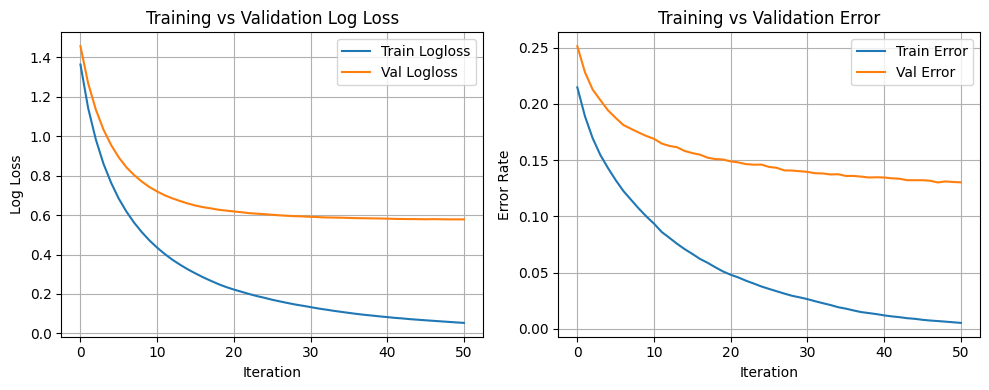

In [12]:
# --- Plot logloss ---
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(evals_result['validation_0']['mlogloss'], label='Train Logloss')
plt.plot(evals_result['validation_1']['mlogloss'], label='Val Logloss')
plt.xlabel('Iteration')
plt.ylabel('Log Loss')
plt.title('Training vs Validation Log Loss')
plt.legend()
plt.grid(True)

# --- Plot classification error ---
plt.subplot(1, 2, 2)
plt.plot(evals_result['validation_0']['merror'], label='Train Error')
plt.plot(evals_result['validation_1']['merror'], label='Val Error')
plt.xlabel('Iteration')
plt.ylabel('Error Rate')
plt.title('Training vs Validation Error')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
y_pred = clf.predict(x_val_flat)
cm = confusion_matrix(y_val_enc, y_pred)
print("\nClassification Report:\n", classification_report(y_val_enc, y_pred,target_names=le.classes_))


Classification Report:
               precision    recall  f1-score   support

                   0.00      0.00      0.00        23
           '       0.00      0.00      0.00         1
           -       0.79      0.62      0.70        24
           A       0.86      0.93      0.89      1317
           B       0.83      0.72      0.77       230
           C       0.87      0.84      0.86       331
           D       0.81      0.79      0.80       302
           E       0.90      0.93      0.91      1258
           F       0.83      0.68      0.75        72
           G       0.88      0.82      0.85       161
           H       0.78      0.73      0.75       259
           I       0.87      0.91      0.89       775
           J       0.87      0.74      0.80        72
           K       0.68      0.59      0.63        64
           L       0.92      0.93      0.92       781
           M       0.79      0.77      0.78       383
           N       0.86      0.92      0.89       777
  

c:\Users\thomw\LaptopBackup\UNI\PRML\PRML_Digit_Recognition\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\thomw\LaptopBackup\UNI\PRML\PRML_Digit_Recognition\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\thomw\LaptopBackup\UNI\PRML\PRML_Digit_Recognition\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to contr

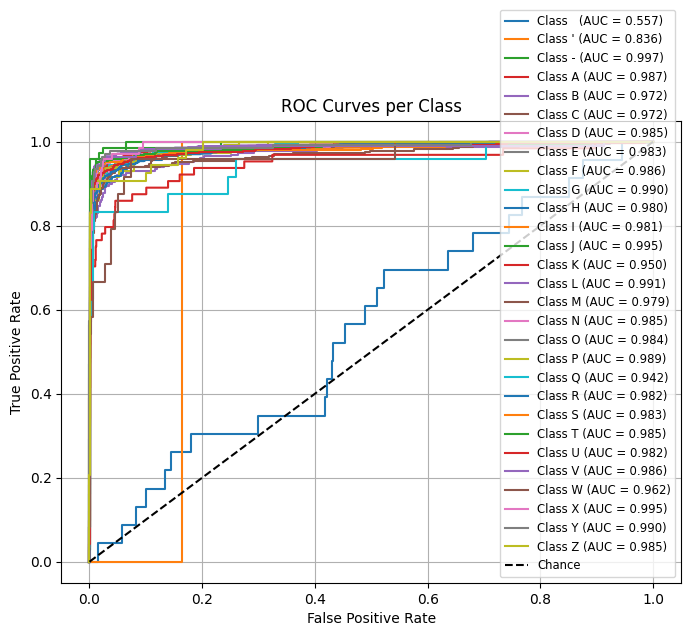

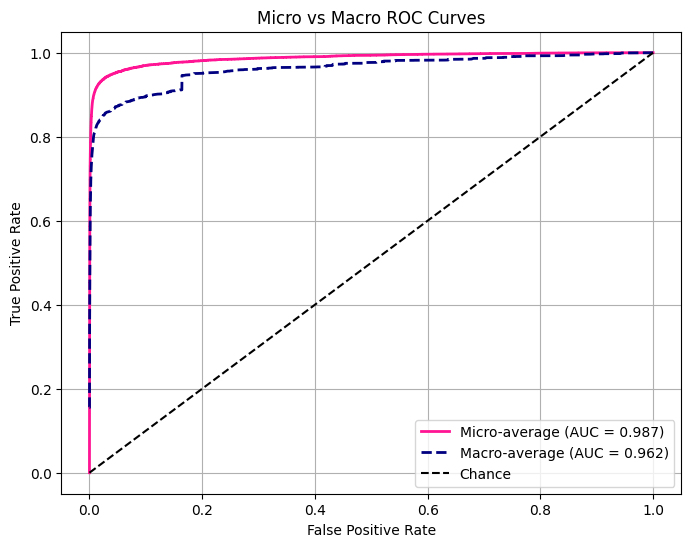

In [18]:
y_pred_proba = est.predict_proba(x_val_flat)
# Get list of classes from the label encoder
classes = le.classes_

# Binarize the labels (one-hot encode)
y_val_bin = label_binarize(y_val_enc, classes=np.arange(len(classes)))
n_classes = y_val_bin.shape[1]

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_val_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Micro-average (considers all classes at once)
fpr["micro"], tpr["micro"], _ = roc_curve(y_val_bin.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Macro-average (average of all class AUCs)
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

plt.figure(figsize=(8, 6))
for i, label in enumerate(classes):
    plt.plot(fpr[i], tpr[i], lw=1.5, label=f'Class {label} (AUC = {roc_auc[i]:.3f})')
plt.plot([0, 1], [0, 1], 'k--', label='Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves per Class')
plt.legend(loc='lower right', fontsize='small')
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average (AUC = {roc_auc["micro"]:.3f})',
         color='deeppink', linestyle='-', linewidth=2)
plt.plot(fpr["macro"], tpr["macro"],
         label=f'Macro-average (AUC = {roc_auc["macro"]:.3f})',
         color='navy', linestyle='--', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label='Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Micro vs Macro ROC Curves')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

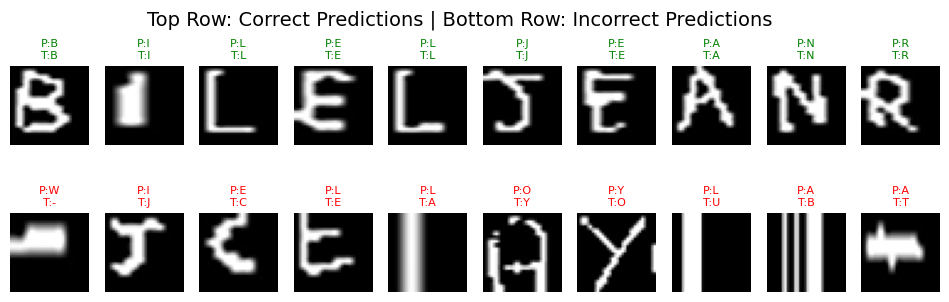

In [14]:
y_pred_decoded = le.inverse_transform(y_pred)

correct_indices = np.where(y_pred_decoded == y_val)[0]
incorrect_indices = np.where(y_pred_decoded != y_val)[0]

# Visualize first 10 correct and incorrect predictions
plt.figure(figsize=(12, 3.5))

# First row: correct predictions
for i, idx in enumerate(correct_indices[:10]):
    plt.subplot(2, 10, i+1)
    plt.imshow(x_val[idx], cmap='gray')
    plt.title(f"P:{y_pred_decoded[idx]}\nT:{y_val[idx]}", color='green', fontsize=8)
    plt.axis('off')

# Second row: incorrect predictions
for i, idx in enumerate(incorrect_indices[:10]):
    plt.subplot(2, 10, 10 + i + 1)
    plt.imshow(x_val[idx], cmap='gray')
    plt.title(f"P:{y_pred_decoded[idx]}\nT:{y_val[idx]}", color='red', fontsize=8)
    plt.axis('off')

plt.suptitle("Top Row: Correct Predictions | Bottom Row: Incorrect Predictions", fontsize=14)
plt.show()

In [15]:
import joblib
joblib.dump(clf, "XGBoost2.pkl")
#joblib save us

['XGBoost2.pkl']